In [45]:
import os
import math
import pickle
import tqdm
from multiprocessing import Pool

import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from src.utils import preprocess_backtest_data, preprocess_backtest_data_rolling_univ
from src.backtest import aggregate_weights, backtest, backtest_baseline

device = torch.device('cpu')

In [2]:
sns.set()
sns.set_style(style='white')

In [3]:
backtest_start = '2019-11'
backtest_end = '2025-06'
trading_cost = 0.004
lagging = 2

In [4]:
universes = ['universe1', 'universe5']
ports = ['MaxSharpe', 'MaxSortino']
models = ['Mamba', 'TRF', 'LSTM']
optimizers = ['sophia']

In [5]:
universe1_backtest_yearmons, universe1_backtest_data, universe1_missing_mask = preprocess_backtest_data(f'data/universe1.csv', device)
universe5_backtest_yearmons, universe5_backtest_data, universe5_missing_mask = preprocess_backtest_data(f'data/universe5.csv', device)

In [6]:
directory = 'result/'
for universe in universes:
    file_name = universe + '_ensemble_maxsortino_lstm_sophia_21_1000_all_weights'
    if os.path.exists(directory + file_name + '.pkl'):
        with open(directory + file_name + '.pkl', 'rb') as f:
            object = pickle.load(f)
        exec(file_name + ' = object')
    else:
        print(file_name)

In [7]:
num_samples = [2 ** x for x in range(7)]

In [8]:
all_weights = universe1_ensemble_maxsortino_lstm_sophia_21_1000_all_weights
yearmons = universe1_backtest_yearmons
data = universe1_backtest_data
missing_mask = universe1_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)
        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)
        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [9]:
with Pool(len(num_samples)) as p:
    universe1_lstm_all_backtest_weight = p.map(simulate, num_samples)

In [10]:
all_weights = universe5_ensemble_maxsortino_lstm_sophia_21_1000_all_weights
yearmons = universe5_backtest_yearmons
data = universe5_backtest_data
missing_mask = universe5_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

common_index = all_weights[0].index.map(lambda x: data.resample('M').ffill().loc[x].index[-1])

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)

        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)

        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [11]:
with Pool(len(num_samples)) as p:
    universe5_lstm_all_backtest_weight = p.map(simulate, num_samples)

In [12]:
universe1_lstm_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe1_lstm_all_backtest_weight]
universe5_lstm_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe5_lstm_all_backtest_weight]

universe1_lstm_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe1_lstm_all_backtest_weight]
universe5_lstm_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe5_lstm_all_backtest_weight]

universe1_lstm_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe1_lstm_all_backtest_weight]
universe5_lstm_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe5_lstm_all_backtest_weight]

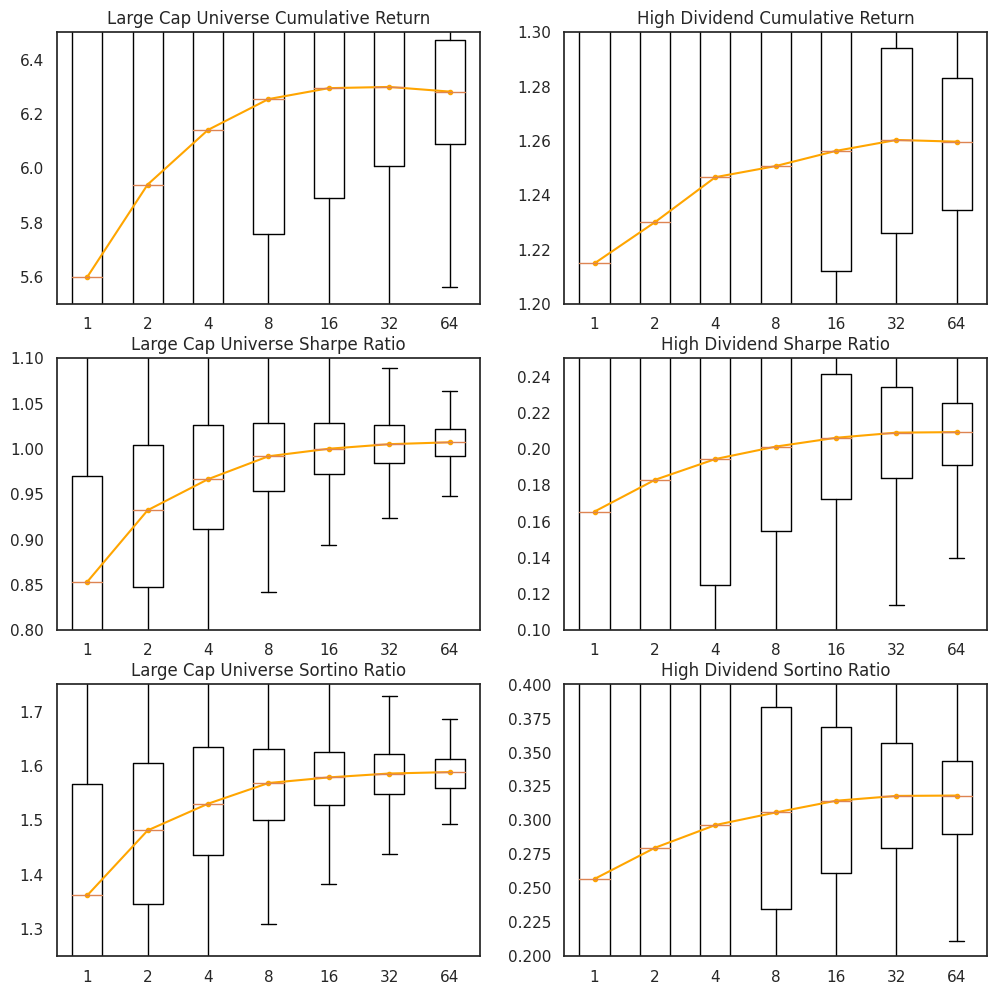

In [13]:
markersize = 3


fig = plt.figure(figsize = (12, 12))


ax = fig.add_subplot(3, 2, 1)

data = universe1_lstm_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Large Cap Universe Cumulative Return')
ax.set_ylim(5.5, 6.5)

ax = fig.add_subplot(3, 2, 2)

data = universe5_lstm_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('High Dividend Cumulative Return')
ax.set_ylim(1.2, 1.3)


ax = fig.add_subplot(3, 2, 3)

data = universe1_lstm_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Large Cap Universe Sharpe Ratio')
ax.set_ylim(0.8, 1.1)

ax = fig.add_subplot(3, 2, 4)

data = universe5_lstm_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('High Dividend Sharpe Ratio')
ax.set_ylim(0.1, 0.25)


ax = fig.add_subplot(3, 2, 5)

data = universe1_lstm_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Large Cap Universe Sortino Ratio')
ax.set_ylim(1.25, 1.75)

ax = fig.add_subplot(3, 2, 6)

data = universe5_lstm_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('High Dividend Sortino Ratio')
ax.set_ylim(0.2, 0.4)


plt.show()

In [14]:
directory = 'result/'
for universe in universes:
    file_name = universe + '_ensemble_maxsortino_mamba_sophia_21_1000_all_weights'
    if os.path.exists(directory + file_name + '.pkl'):
        with open(directory + file_name + '.pkl', 'rb') as f:
            object = pickle.load(f)
        exec(file_name + ' = object')
    else:
        print(file_name)

In [15]:
num_samples = [2 ** x for x in range(7)]

In [16]:
all_weights = universe1_ensemble_maxsortino_mamba_sophia_21_1000_all_weights
yearmons = universe1_backtest_yearmons
data = universe1_backtest_data
missing_mask = universe1_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)
        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)
        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [17]:
with Pool(len(num_samples)) as p:
    universe1_mamba_all_backtest_weight = p.map(simulate, num_samples)

In [18]:
all_weights = universe5_ensemble_maxsortino_mamba_sophia_21_1000_all_weights
yearmons = universe5_backtest_yearmons
data = universe5_backtest_data
missing_mask = universe5_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

common_index = all_weights[0].index.map(lambda x: data.resample('M').ffill().loc[x].index[-1])

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)

        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)

        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [19]:
with Pool(len(num_samples)) as p:
    universe5_mamba_all_backtest_weight = p.map(simulate, num_samples)

In [20]:
universe1_mamba_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe1_mamba_all_backtest_weight]
universe5_mamba_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe5_mamba_all_backtest_weight]

universe1_mamba_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe1_mamba_all_backtest_weight]
universe5_mamba_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe5_mamba_all_backtest_weight]

universe1_mamba_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe1_mamba_all_backtest_weight]
universe5_mamba_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe5_mamba_all_backtest_weight]

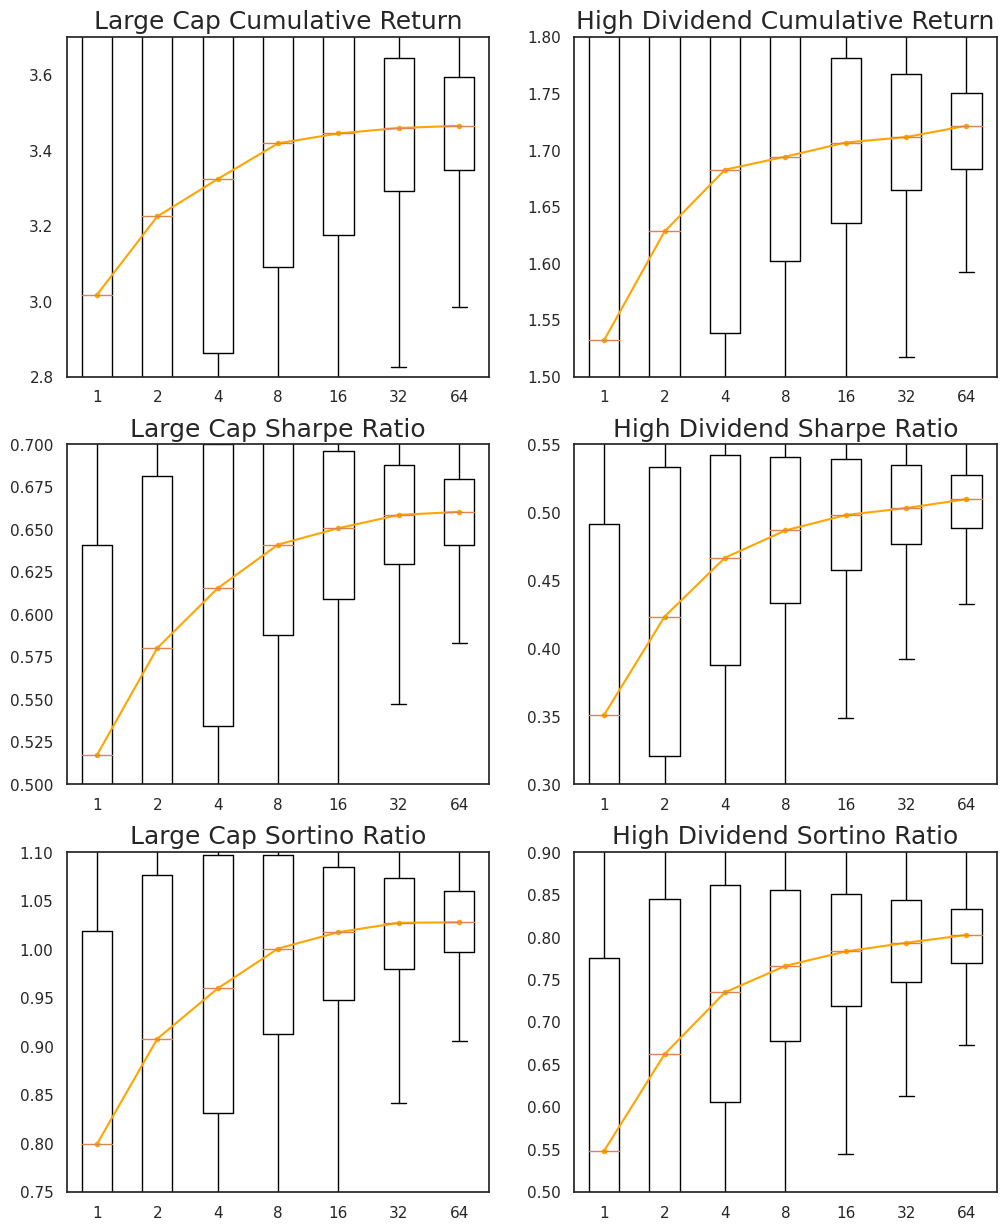

In [44]:
markersize = 3


fig = plt.figure(figsize = (12, 15))

ax = fig.add_subplot(3, 2, 1)

data = universe1_mamba_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Large Cap Cumulative Return', fontdict={'fontsize': 18})
ax.set_ylim(2.8, 3.7)

ax = fig.add_subplot(3, 2, 2)

data = universe5_mamba_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('High Dividend Cumulative Return', fontdict={'fontsize': 18})
ax.set_ylim(1.5, 1.8)


ax = fig.add_subplot(3, 2, 3)

data = universe1_mamba_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Large Cap Sharpe Ratio', fontdict={'fontsize': 18})
ax.set_ylim(0.5, 0.7)

ax = fig.add_subplot(3, 2, 4)

data = universe5_mamba_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('High Dividend Sharpe Ratio', fontdict={'fontsize': 18})
ax.set_ylim(0.3, 0.55)


ax = fig.add_subplot(3, 2, 5)

data = universe1_mamba_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Large Cap Sortino Ratio', fontdict={'fontsize': 18})
ax.set_ylim(0.75, 1.1)

ax = fig.add_subplot(3, 2, 6)

data = universe5_mamba_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('High Dividend Sortino Ratio', fontdict={'fontsize': 18})
ax.set_ylim(0.5, 0.9)

plt.show()

In [52]:
universes = ['universe7', 'universe8']

In [46]:
universe7_backtest_yearmons, universe7_backtest_data, universe7_missing_mask = preprocess_backtest_data_rolling_univ(f'data/universe7.csv', device)
universe8_backtest_yearmons, universe8_backtest_data, universe8_missing_mask = preprocess_backtest_data_rolling_univ(f'data/universe8.csv', device)

In [53]:
directory = 'result/'
for universe in universes:
    file_name = universe + '_ensemble_maxsortino_lstm_sophia_21_1000_all_weights'
    if os.path.exists(directory + file_name + '.pkl'):
        with open(directory + file_name + '.pkl', 'rb') as f:
            object = pickle.load(f)
        exec(file_name + ' = object')
    else:
        print(file_name)

In [55]:
num_samples = [2 ** x for x in range(7)]

In [56]:
all_weights = universe7_ensemble_maxsortino_lstm_sophia_21_1000_all_weights
yearmons = universe7_backtest_yearmons
data = universe7_backtest_data
missing_mask = universe7_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)
        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)
        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [57]:
with Pool(len(num_samples)) as p:
    universe7_lstm_all_backtest_weight = p.map(simulate, num_samples)

In [58]:
all_weights = universe8_ensemble_maxsortino_lstm_sophia_21_1000_all_weights
yearmons = universe8_backtest_yearmons
data = universe8_backtest_data
missing_mask = universe8_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

common_index = all_weights[0].index.map(lambda x: data.resample('M').ffill().loc[x].index[-1])

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)

        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)

        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [59]:
with Pool(len(num_samples)) as p:
    universe8_lstm_all_backtest_weight = p.map(simulate, num_samples)

In [60]:
universe7_lstm_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe7_lstm_all_backtest_weight]
universe8_lstm_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe8_lstm_all_backtest_weight]

universe7_lstm_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe7_lstm_all_backtest_weight]
universe8_lstm_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe8_lstm_all_backtest_weight]

universe7_lstm_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe7_lstm_all_backtest_weight]
universe8_lstm_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe8_lstm_all_backtest_weight]

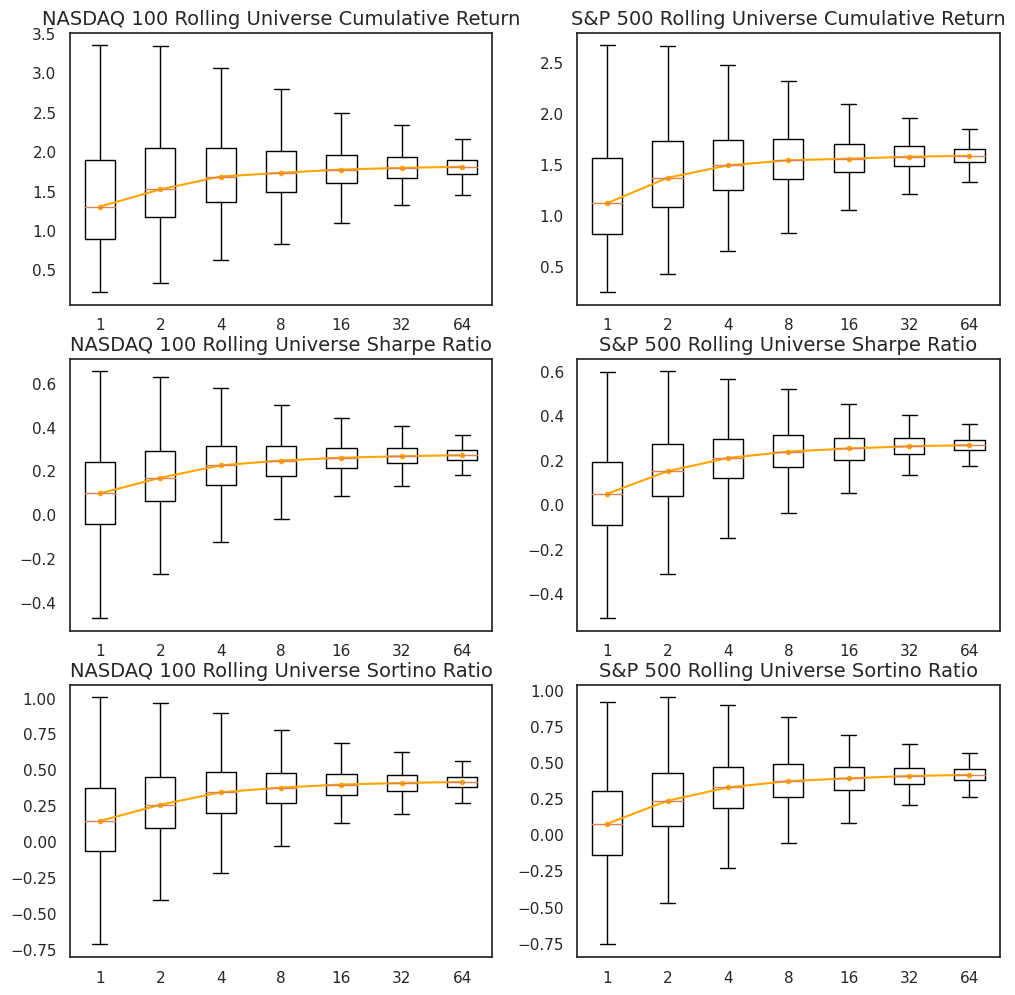

In [76]:
markersize = 3


fig = plt.figure(figsize = (12, 12))


ax = fig.add_subplot(3, 2, 1)

data = universe7_lstm_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('NASDAQ 100 Rolling Universe Cumulative Return', fontdict={'fontsize': 14})
#ax.set_ylim(5.5, 6.5)

ax = fig.add_subplot(3, 2, 2)

data = universe8_lstm_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('S&P 500 Rolling Universe Cumulative Return', fontdict={'fontsize': 14})
#ax.set_ylim(1.2, 1.3)


ax = fig.add_subplot(3, 2, 3)

data = universe7_lstm_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('NASDAQ 100 Rolling Universe Sharpe Ratio', fontdict={'fontsize': 14})
#ax.set_ylim(0.8, 1.1)

ax = fig.add_subplot(3, 2, 4)

data = universe8_lstm_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('S&P 500 Rolling Universe Sharpe Ratio', fontdict={'fontsize': 14})
#ax.set_ylim(0.1, 0.25)


ax = fig.add_subplot(3, 2, 5)

data = universe7_lstm_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('NASDAQ 100 Rolling Universe Sortino Ratio', fontdict={'fontsize': 14})
#ax.set_ylim(1.25, 1.75)

ax = fig.add_subplot(3, 2, 6)

data = universe8_lstm_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('S&P 500 Rolling Universe Sortino Ratio', fontdict={'fontsize': 14})
#ax.set_ylim(0.2, 0.4)


plt.show()

In [62]:
directory = 'result/'
for universe in universes:
    file_name = universe + '_ensemble_maxsortino_mamba_sophia_21_1000_all_weights'
    if os.path.exists(directory + file_name + '.pkl'):
        with open(directory + file_name + '.pkl', 'rb') as f:
            object = pickle.load(f)
        exec(file_name + ' = object')
    else:
        print(file_name)

In [63]:
num_samples = [2 ** x for x in range(7)]

In [64]:
all_weights = universe7_ensemble_maxsortino_mamba_sophia_21_1000_all_weights
yearmons = universe7_backtest_yearmons
data = universe7_backtest_data
missing_mask = universe7_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)
        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)
        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [65]:
with Pool(len(num_samples)) as p:
    universe7_mamba_all_backtest_weight = p.map(simulate, num_samples)

In [66]:
all_weights = universe8_ensemble_maxsortino_mamba_sophia_21_1000_all_weights
yearmons = universe8_backtest_yearmons
data = universe8_backtest_data
missing_mask = universe8_missing_mask

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

common_index = all_weights[0].index.map(lambda x: data.resample('M').ffill().loc[x].index[-1])

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)

        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)

        results.append(backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging))

    return results
    

In [67]:
with Pool(len(num_samples)) as p:
    universe8_mamba_all_backtest_weight = p.map(simulate, num_samples)

In [68]:
universe7_mamba_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe7_mamba_all_backtest_weight]
universe8_mamba_ensemble_data_cr = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe8_mamba_all_backtest_weight]

universe7_mamba_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe7_mamba_all_backtest_weight]
universe8_mamba_ensemble_data_sharpe = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe8_mamba_all_backtest_weight]

universe7_mamba_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe7_mamba_all_backtest_weight]
universe8_mamba_ensemble_data_sortino = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe8_mamba_all_backtest_weight]

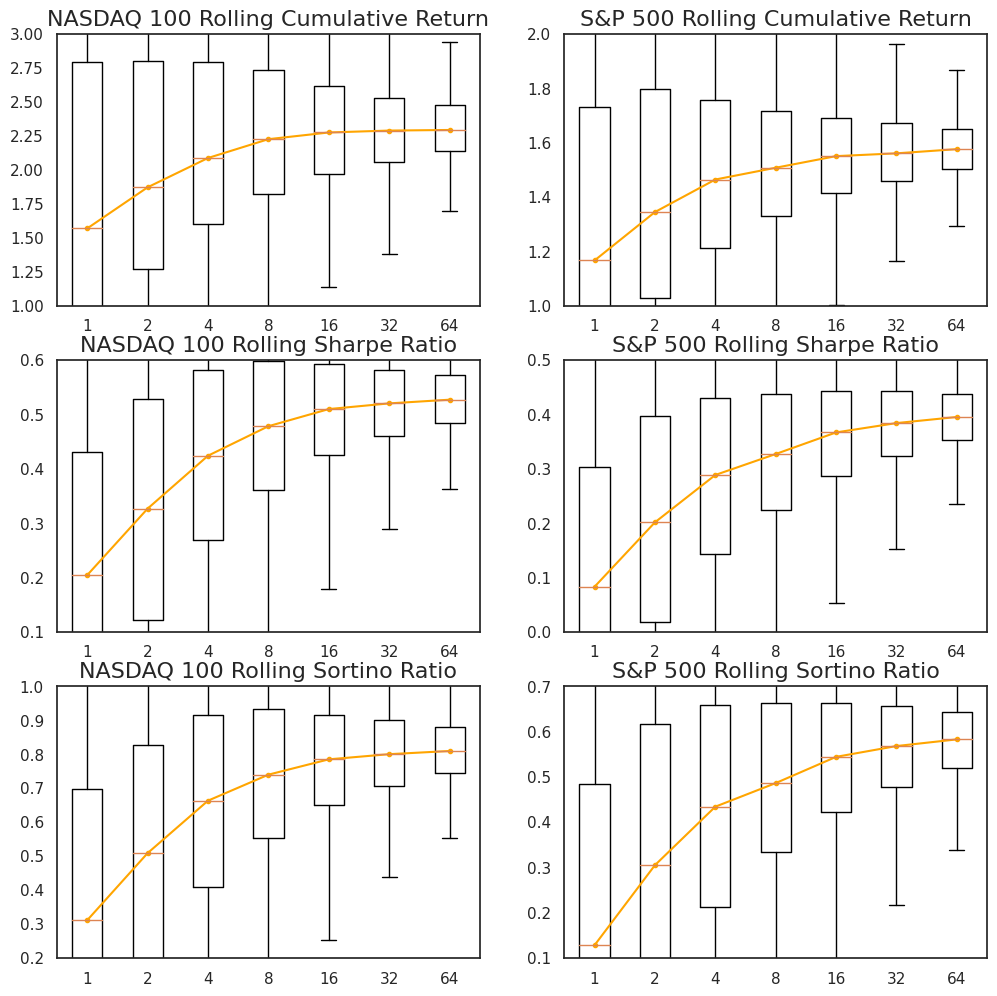

In [84]:
markersize = 3


fig = plt.figure(figsize = (12, 12))


ax = fig.add_subplot(3, 2, 1)

data = universe7_mamba_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('NASDAQ 100 Rolling Cumulative Return', fontdict={'fontsize': 16})
ax.set_ylim(1, 3)

ax = fig.add_subplot(3, 2, 2)

data = universe8_mamba_ensemble_data_cr

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('S&P 500 Rolling Cumulative Return', fontdict={'fontsize': 16})
ax.set_ylim(1, 2)


ax = fig.add_subplot(3, 2, 3)

data = universe7_mamba_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('NASDAQ 100 Rolling Sharpe Ratio', fontdict={'fontsize': 16})
ax.set_ylim(0.1, 0.6)

ax = fig.add_subplot(3, 2, 4)

data = universe8_mamba_ensemble_data_sharpe

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('S&P 500 Rolling Sharpe Ratio', fontdict={'fontsize': 16})
ax.set_ylim(0.0, 0.5)


ax = fig.add_subplot(3, 2, 5)

data = universe7_mamba_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('NASDAQ 100 Rolling Sortino Ratio', fontdict={'fontsize': 16})
ax.set_ylim(0.2, 1)

ax = fig.add_subplot(3, 2, 6)

data = universe8_mamba_ensemble_data_sortino

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('S&P 500 Rolling Sortino Ratio', fontdict={'fontsize': 16})
ax.set_ylim(0.1, 0.7)


plt.show()